In [ ]:
import os
import pandas as pd
import numpy as np
import string


import re
import glob
import matplotlib.pyplot as plt

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Data
aisles = spark.read.csv("/content/drive/MyDrive/CC_Project/aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("/content/drive/MyDrive/CC_Project/departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("/content/drive/MyDrive/CC_Project/order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("/content/drive/MyDrive/CC_Project/order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("/content/drive/MyDrive/CC_Project/orders.csv", header=True, inferSchema=True)
products = spark.read.csv("/content/drive/MyDrive/CC_Project/products.csv", header=True, inferSchema=True)

# Create Temporary Tables
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

In [ ]:
aisles.show(100)

+--------+--------------------+
|aisle_id|               aisle|
+--------+--------------------+
|       1|prepared soups sa...|
|       2|   specialty cheeses|
|       3| energy granola bars|
|       4|       instant foods|
|       5|marinades meat pr...|
|       6|               other|
|       7|       packaged meat|
|       8|     bakery desserts|
|       9|         pasta sauce|
|      10|    kitchen supplies|
|      11|    cold flu allergy|
|      12|         fresh pasta|
|      13|      prepared meals|
|      14|tofu meat alterna...|
|      15|    packaged seafood|
|      16|         fresh herbs|
|      17|  baking ingredients|
|      18|bulk dried fruits...|
|      19|       oils vinegars|
|      20|        oral hygiene|
|      21|     packaged cheese|
|      22|           hair care|
|      23|       popcorn jerky|
|      24|        fresh fruits|
|      25|                soap|
|      26|              coffee|
|      27|       beers coolers|
|      28|           red wines|
|      2

In [ ]:
unique_aisles_count = spark.sql("SELECT COUNT(DISTINCT aisle) as unique_aisles_count FROM aisles")

# Show the result
unique_aisles_count.show()

+-------------------+
|unique_aisles_count|
+-------------------+
|                134|
+-------------------+



In [ ]:
# Check for null values in the "aisle" column
null_check = spark.sql("SELECT COUNT(*) as null_count FROM aisles WHERE aisle IS NULL")

# Show the result
null_check.show()


+----------+
|null_count|
+----------+
|         0|
+----------+



In [ ]:
departments.show(50)

+-------------+---------------+
|department_id|     department|
+-------------+---------------+
|            1|         frozen|
|            2|          other|
|            3|         bakery|
|            4|        produce|
|            5|        alcohol|
|            6|  international|
|            7|      beverages|
|            8|           pets|
|            9|dry goods pasta|
|           10|           bulk|
|           11|  personal care|
|           12|   meat seafood|
|           13|         pantry|
|           14|      breakfast|
|           15|   canned goods|
|           16|     dairy eggs|
|           17|      household|
|           18|         babies|
|           19|         snacks|
|           20|           deli|
|           21|        missing|
+-------------+---------------+



In [ ]:
unique_departments = spark.sql("SELECT DISTINCT department FROM departments")
unique_departments.show()

+---------------+
|     department|
+---------------+
|      beverages|
|   meat seafood|
|         frozen|
|           deli|
|dry goods pasta|
|           bulk|
|          other|
|         babies|
|         bakery|
|        produce|
|         pantry|
|     dairy eggs|
|   canned goods|
|  personal care|
|      breakfast|
|        missing|
|           pets|
|      household|
|        alcohol|
|  international|
+---------------+
only showing top 20 rows



In [ ]:
order_products_prior.show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
|       2|     17794|                6|        1|
|       2|     40141|                7|        1|
|       2|      1819|                8|        1|
|       2|     43668|                9|        0|
|       3|     33754|                1|        1|
|       3|     24838|                2|        1|
|       3|     17704|                3|        1|
|       3|     21903|                4|        1|
|       3|     17668|                5|        1|
|       3|     46667|                6|        1|
|       3|     17461|                7|        1|
|       3|     32665|                8|        1|


In [ ]:
order_products_train.show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
|       1|     13176|                6|        0|
|       1|     47209|                7|        0|
|       1|     22035|                8|        1|
|      36|     39612|                1|        0|
|      36|     19660|                2|        1|
|      36|     49235|                3|        0|
|      36|     43086|                4|        1|
|      36|     46620|                5|        1|
|      36|     34497|                6|        1|
|      36|     48679|                7|        1|
|      36|     46979|                8|        1|
|      38|     11913|                1|        0|


In [ ]:
orders.show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
| 3367565|      1|   prior|           6|        2|                7|                  19.0|
|  550135|      1|   prior|           7|        1|                9|                  20.0|
| 3108588|      1|   prior|           8|        1|               14|            

In [ ]:
products.show()

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
|         6|        Dry Nose Oil|      11|           11|
|         7|Pure Coconut Wate...|      98|            7|
|         8|Cut Russet Potato...|     116|            1|
|         9|Light Strawberry ...|     120|           16|
|        10|Sparkling Orange ...|     115|            7|
|        11|   Peach Mango Juice|      31|            7|
|        12|Chocolate Fudge L...|     119|            1|
|        13|   Saline Nasal Mist|      11|           11|
|        14|Fresh Scent Dishw...|      74|           17|
|        15|Overnight Diapers..

In [ ]:
unique_department_count = spark.sql("SELECT COUNT(DISTINCT department) as unique_count FROM departments")

In [ ]:
query = """
SELECT
  COUNT(order_id) AS total_orders,
  CASE
    WHEN order_dow = 0 THEN 'Sunday'
    WHEN order_dow = 1 THEN 'Monday'
    WHEN order_dow = 2 THEN 'Tuesday'
    WHEN order_dow = 3 THEN 'Wednesday'
    WHEN order_dow = 4 THEN 'Thursday'
    WHEN order_dow = 5 THEN 'Friday'
    WHEN order_dow = 6 THEN 'Saturday'
  END AS day_of_week
FROM orders
GROUP BY order_dow
ORDER BY total_orders DESC
"""

result = spark.sql(query)
result.show()


+------------+-----------+
|total_orders|day_of_week|
+------------+-----------+
|      600905|     Sunday|
|      587478|     Monday|
|      467260|    Tuesday|
|      453368|     Friday|
|      448761|   Saturday|
|      436972|  Wednesday|
|      426339|   Thursday|
+------------+-----------+



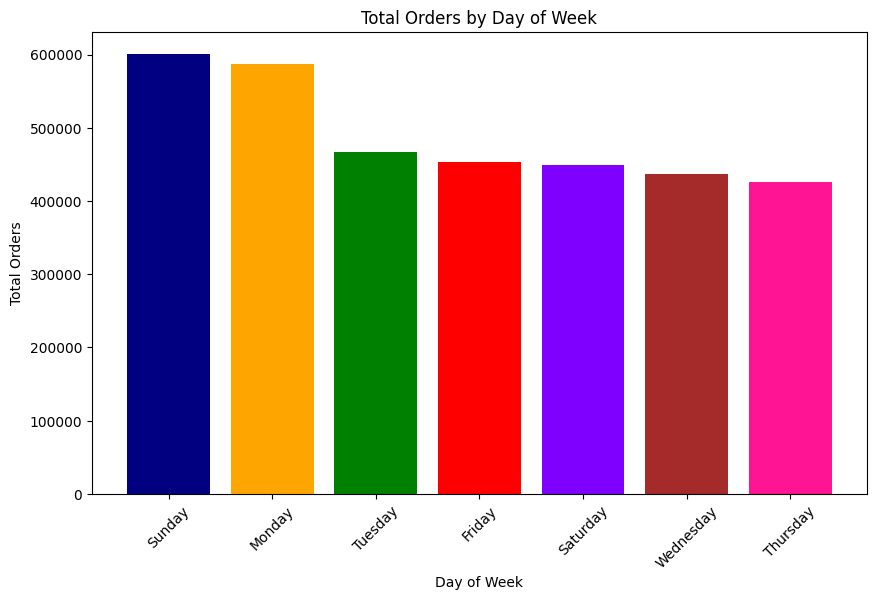

In [ ]:
result_pandas = result.toPandas()

# Create a bar chart with different colors
plt.figure(figsize=(10, 6))
colors = ['#000080', 'orange', 'green', 'red', '#8000FF', 'brown', '#FF1493']
plt.bar(result_pandas['day_of_week'], result_pandas['total_orders'], color=colors)
plt.xlabel('Day of Week')
plt.ylabel('Total Orders')
plt.title('Total Orders by Day of Week')
plt.xticks(rotation=45)
plt.show()

In [ ]:
query = """
select
  count(order_id) as total_orders,
  order_hour_of_day as hour
  from orders
 group by order_hour_of_day
 order by order_hour_of_day
"""

result = spark.sql(query)
result.show()

+------------+----+
|total_orders|hour|
+------------+----+
|       22758|   0|
|       12398|   1|
|        7539|   2|
|        5474|   3|
|        5527|   4|
|        9569|   5|
|       30529|   6|
|       91868|   7|
|      178201|   8|
|      257812|   9|
|      288418|  10|
|      284728|  11|
|      272841|  12|
|      277999|  13|
|      283042|  14|
|      283639|  15|
|      272553|  16|
|      228795|  17|
|      182912|  18|
|      140569|  19|
+------------+----+
only showing top 20 rows



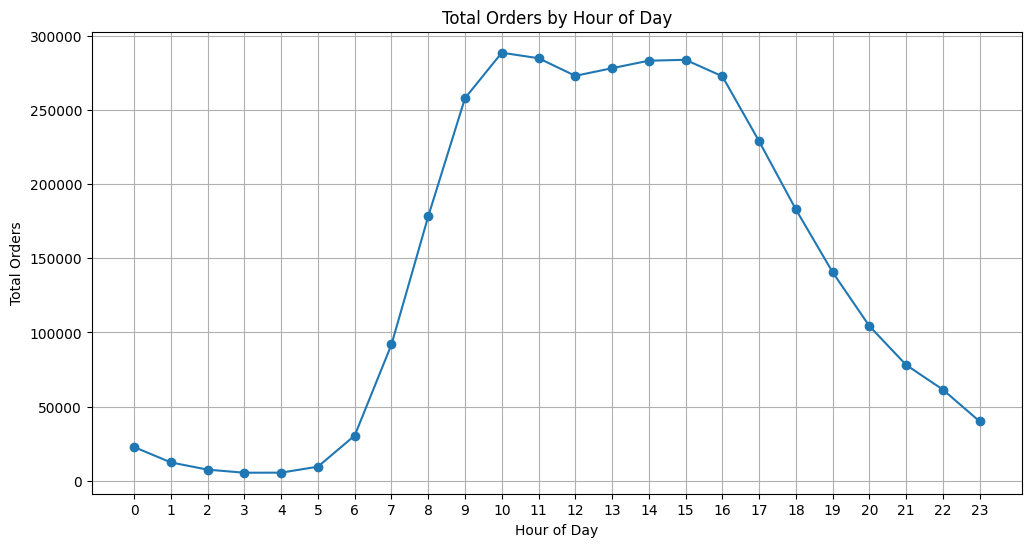

In [ ]:
result_pandas = result.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(result_pandas['hour'], result_pandas['total_orders'], marker='o')
plt.title('Total Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Orders')
plt.grid(True)
plt.xticks(range(0, 24))  # Assuming hours are from 0 to 23
plt.show()

In [ ]:
query = """
select d.department, count(distinct p.product_id) as products
  from products p
    inner join departments d
      on d.department_id = p.department_id
 group by d.department
 order by products desc
 limit 10
"""

result = spark.sql(query)
result.show()

+---------------+--------+
|     department|products|
+---------------+--------+
|  personal care|    6563|
|         snacks|    6264|
|         pantry|    5371|
|      beverages|    4365|
|         frozen|    4007|
|     dairy eggs|    3449|
|      household|    3084|
|   canned goods|    2092|
|dry goods pasta|    1858|
|        produce|    1684|
+---------------+--------+



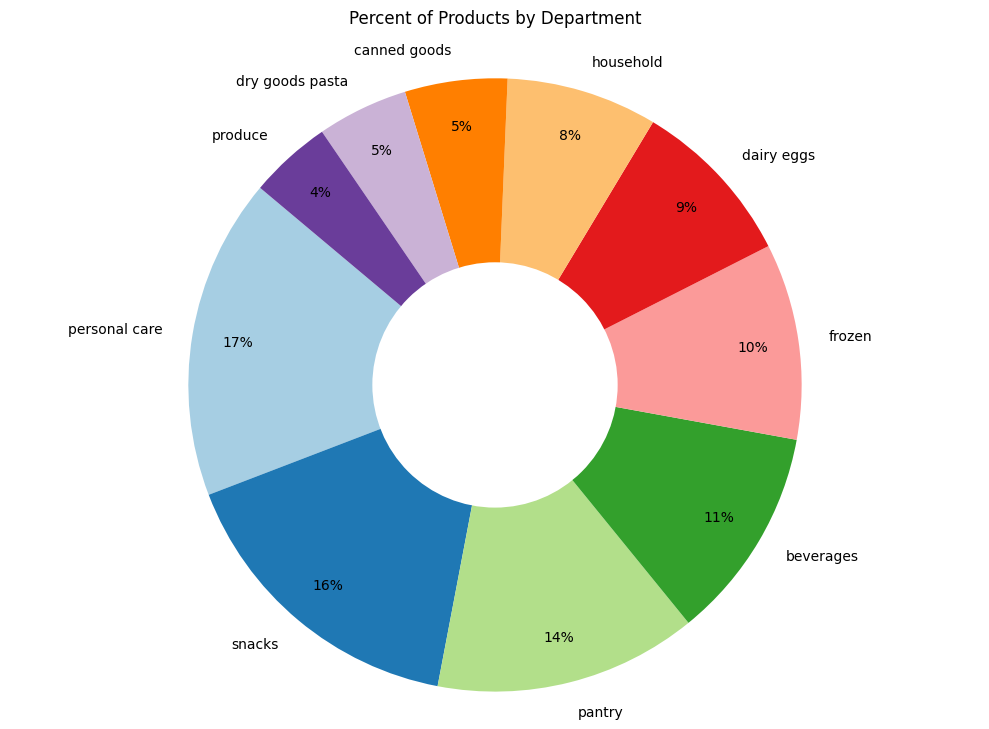

In [ ]:
result_pandas = result.toPandas()
# Data for plotting
departments = result_pandas['department']
products = result_pandas['products']
colors = plt.cm.Paired(range(len(departments)))  # Generate distinct colors

# Create pie chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(products, labels=departments, colors=colors, autopct='%1.0f%%', startangle=140, pctdistance=0.85)

# Convert to donut chart
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()

# Add title
plt.title("Percent of Products by Department\n")

# Update autotexts to show only two decimals
for autotext in autotexts:
    autotext.set_color('black')

plt.show()

## Organize Shopping Basket

To prepare our data for downstream processing, we will organize our data by shopping basket. That is, each row of our DataFrame represents an order_id with each items column containing an array of items.

In [ ]:
# Organize the data by shopping basket
from pyspark.sql.functions import collect_set, col, count
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')

In [ ]:
baskets.show(20, truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                        

In [ ]:
from pyspark.ml.fpm import FPGrowth

In [ ]:
# Extract out the items
baskets_df = spark.sql("SELECT items FROM baskets")

# Convert the DataFrame column to the appropriate format
# Assuming `items` is an array of strings as per your code
baskets_ds = baskets_df.select("items")

### FPGrowth Algorithm

In [ ]:
# Use FPGrowth Algorithm
fpgrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)
model = fpgrowth.fit(baskets_ds)

In [ ]:
# Calculate frequent itemsets
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
query = """
select items, freq from mostPopularItemInABasket where size(items) > 2 order by freq desc limit 20
"""

result = spark.sql(query)
result.show(20, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------
 items | [Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas] 
 freq  | 710                                                                  
-RECORD 1---------------------------------------------------------------------
 items | [Organic Raspberries, Organic Strawberries, Bag of Organic Bananas]  
 freq  | 649                                                                  
-RECORD 2---------------------------------------------------------------------
 items | [Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas] 
 freq  | 587                                                                  
-RECORD 3---------------------------------------------------------------------
 items | [Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas]  
 freq  | 531                                                                  
-RECORD 4-------------------------------------------

### Review Association Rules

In addition to freqItemSets, the FP-growth model also generates associationRules. For example, if a shopper purchases peanut butter, what is the probability (or confidence) that they will also purchase jelly.  For more information, a good reference is [Susan Li's A Gentle Introduction on Market Basket Analysis — Association Rules](https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce).

In [ ]:
# Assuming 'model' is your already trained FPGrowthModel

# Generate association rules
if_then = model.associationRules

# Create or replace temporary view
if_then.createOrReplaceTempView("ifThen")

# Now you can use this view to query with Spark SQL

A good way to think about association rules is that model determines that **if** you purchased something (i.e. the antecedent), **then** you will purchase this other thing (i.e. the consequent) with the following **confidence**.

In [ ]:
query = """
select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence, lift, support from ifThen order by confidence desc
"""

result = spark.sql(query)
result.show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------
 antecedent (if)   | [Organic Raspberries, Organic Hass Avocado, Organic Strawberries]  
 consequent (then) | [Bag of Organic Bananas]                                           
 confidence        | 0.5984251968503937                                                 
 lift              | 5.072272070642333                                                  
 support           | 0.0017376856770495927                                              
-RECORD 1-------------------------------------------------------------------------------
 antecedent (if)   | [Organic Cucumber, Organic Hass Avocado, Organic Strawberries]     
 consequent (then) | [Bag of Organic Bananas]                                           
 confidence        | 0.546875                                                           
 lift              | 4.635330870478036                                                  
 support           | 

As can be seen in the preceding graph, there is relatively strong confidence that if a shopper has organic raspberries, organic avocados, and organic strawberries in their basket, then it may make sense to recommend organic bananas as well. Interestingly, the top 10 (based on descending confidence) association rules - i.e. purchase recommendations - are associated with organic bananas or bananas.

In [ ]:
from pyspark.sql import Row
from pyspark.sql.functions import col

In [ ]:
# # Example new data
# new_data = [
#     Row(items=["Deli Fresh Smoked Ham", "Plain Fat Free Yogurt", "Light Bulbs, Soft White, 40W"]),
#     Row(items=["Mango Peach Jam", "Issimo Mochaccino Iced Coffee Drink with Domori cocoa and lowfat milk", "ProActive Health Large Breed Adult Dog Food"])
# ]
# new_df = spark.createDataFrame(new_data)

# # Transform new data to get predictions
# predictions = model.transform(new_df)

In [ ]:
# Example new data
new_data = [
    Row(items=["Organic Hass Avocado", "Organic Carrot Bunch", "Organic Strawberries"]), # Basket 1
    Row(items=["Organic Fuji Apple", "Organic Hass Avocado", "Organic D'Anjou Pears", "Organic Large Brown Grade AA Cage Free Eggs"])   # Basket 2
]
new_df = spark.createDataFrame(new_data)

# Transform new data to get predictions
predictions = model.transform(new_df)

In [ ]:
# Show the results
# predictions.show(5, truncate=False)

In [ ]:
# # Exploding the predictions
# exploded_predictions = predictions.withColumn("predictedItem", explode(col("prediction")))

In [ ]:
# # First, check the schema of the predictions DataFrame
# predictions.printSchema()

## **Predictions**

In [ ]:
from pyspark.sql.functions import col, slice

# Assuming 'predictions' is your DataFrame containing the predictions
# where each row has an array column named 'prediction'
# Take only the top 25 elements from the 'prediction' array for each row
top_25_predictions = predictions.withColumn("top_25_predictions", slice(col("prediction"), 1, 25))

# Display the DataFrame with the top 25 predictions
top_25_predictions.select("items", "top_25_predictions").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                         |top_25_predictions                                                                                                                                                                                                  

In [ ]:
from pyspark.sql.functions import col, explode, array_contains, avg, slice

# Explode the top 25 predictions to get individual items
exploded_top_25 = top_25_predictions.withColumn("predictedItem", explode(col("top_25_predictions")))

In [ ]:
# Get the association rules
association_rules = model.associationRules

In [ ]:
association_rules.show(truncate=False)

+----------------------------+-------------------------+-------------------+------------------+---------------------+
|antecedent                  |consequent               |confidence         |lift              |support              |
+----------------------------+-------------------------+-------------------+------------------+---------------------+
|[Yellow Onions, Large Lemon]|[Limes]                  |0.23962516733601072|5.2114998476695895|0.0013642356850520924|
|[Yellow Onions, Large Lemon]|[Organic Avocado]        |0.2101740294511379 |3.7220575287156636|0.001196564260073623 |
|[Yellow Onions, Large Lemon]|[Organic Baby Spinach]   |0.19812583668005354|2.656980059786707 |0.0011279714044006128|
|[Yellow Onions, Large Lemon]|[Banana]                 |0.34404283801874164|2.410633169582456 |0.001958707100884848 |
|[Yellow Onions, Banana]     |[Limes]                  |0.14285714285714285|3.106935663375246 |0.001166078546441174 |
|[Yellow Onions, Banana]     |[Organic Avocado]        |

In [ ]:
# Join the exploded top 25 predictions with the association rules
# We're interested in rules where the input basket is the antecedent
# and the predicted items are in the consequent
joined_data = exploded_top_25.join(association_rules,
                                   array_contains(association_rules.consequent, col("predictedItem")))

In [ ]:
# Selecting and displaying the relevant data
# Adjusting the select statement to show the original items and the predictions with their metrics
joined_data.select("items", "predictedItem", "confidence", "lift", "support").show(truncate=False)

+------------------------------------------------------------------+-------------------------------------------+--------------------+------------------+---------------------+
|items                                                             |predictedItem                              |confidence          |lift              |support              |
+------------------------------------------------------------------+-------------------------------------------+--------------------+------------------+---------------------+
|[Organic Hass Avocado, Organic Carrot Bunch, Organic Strawberries]|Organic Large Green Asparagus              |0.016981824857719846|3.052285284598032 |0.001409964255500766 |
|[Organic Hass Avocado, Organic Carrot Bunch, Organic Strawberries]|Organic Large Green Asparagus              |0.022487316604963663|4.041833321124216 |0.0012499142589304088|
|[Organic Hass Avocado, Organic Carrot Bunch, Organic Strawberries]|Organic Baby Rainbow Carrots               |0.01340187259

In [ ]:
from pyspark.sql.functions import avg

# Grouping by 'predictedItem' and calculating the average of 'confidence', 'lift', and 'support'
avg_metrics = joined_data.groupBy("predictedItem").agg(
    avg("confidence").alias("avg_confidence"),
    avg("lift").alias("avg_lift"),
    avg("support").alias("avg_support")
)

# Display the results
avg_metrics.show(truncate=False)


+-------------------------------------------+--------------------+------------------+---------------------+
|predictedItem                              |avg_confidence      |avg_lift          |avg_support          |
+-------------------------------------------+--------------------+------------------+---------------------+
|100% Raw Coconut Water                     |0.021933097039909505|2.2171184356775697|0.001666552345240545 |
|Blackberries                               |0.03368768618121582 |4.104111064207195 |0.0015560416333229175|
|Spring Water                               |0.020698457245820083|1.220595000794071 |0.0018794442454404803|
|Banana                                     |0.25429136395255136 |1.7817641553375152|0.0022925216432982073|
|Bag of Organic Bananas                     |0.2760280940398818  |2.3396233973435945|0.0022499290254479483|
|Michigan Organic Kale                      |0.055445895348256856|2.7693187981535727|0.001756739248069873 |
|Organic Basil              

In [ ]:
from pyspark.sql.functions import avg, col

# Grouping by 'predictedItem' and calculating the average of 'confidence', 'lift', and 'support'
avg_metrics = joined_data.groupBy("predictedItem").agg(
    avg("confidence").alias("avg_confidence"),
    avg("lift").alias("avg_lift"),
    avg("support").alias("avg_support")
)

# Sorting the results by 'avg_confidence' in descending order
sorted_avg_metrics = avg_metrics.orderBy(col("avg_confidence").desc())

# Display the results
sorted_avg_metrics.show(truncate=False)

+------------------------------------+--------------------+------------------+---------------------+
|predictedItem                       |avg_confidence      |avg_lift          |avg_support          |
+------------------------------------+--------------------+------------------+---------------------+
|Bag of Organic Bananas              |0.2760280940398818  |2.3396233973435945|0.0022499290254479483|
|Banana                              |0.25429136395255136 |1.7817641553375152|0.0022925216432982073|
|Limes                               |0.16136401510921541 |3.509433293297704 |0.0020825311940723427|
|Organic Yellow Onion                |0.10935249132964608 |3.3445293787579318|0.00196291476448516  |
|Lime Sparkling Water                |0.10032086190394256 |6.695320432123295 |0.0017365131496021907|
|Raspberries                         |0.08086702876341238 |3.2358895934792855|0.002278475727573035 |
|Yellow Onions                       |0.08071254843531003 |2.8150485825753844|0.00193356975

In [ ]:
from pyspark.sql.functions import avg, col, collect_set

# Grouping by 'predictedItem' and calculating the average of 'confidence', 'lift', and 'support'
# and collecting the distinct 'items' associated with each 'predictedItem'
avg_metrics = joined_data.groupBy("predictedItem").agg(
    collect_set("items").alias("associated_items"),
    avg("confidence").alias("avg_confidence"),
    avg("lift").alias("avg_lift"),
    avg("support").alias("avg_support")
)

# Sorting the results by 'avg_confidence' in descending order
sorted_avg_metrics = avg_metrics.orderBy(col("avg_confidence").desc())

# Display the results
sorted_avg_metrics.show(truncate=False)


+------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------------------+---------------------+
|predictedItem                       |associated_items                                                                                                                                                                    |avg_confidence      |avg_lift          |avg_support          |
+------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------------------+---------------------+
|Bag of Organic Bananas              |[[Organic Hass Avocado, Organic Carrot Bunch, Organic Strawberries]]                                                

## Evaluation Metrics

### Basket 1

In [ ]:
# Filter for the specific basket
basket1 = ["Organic Hass Avocado", "Organic Carrot Bunch", "Organic Strawberries"]

# Filter for the specific basket
# Apply a filter for each item in the basket
for item in basket1:
    joined_data_filtered = joined_data.filter(array_contains(col("antecedent"), item))

# Now joined_data_filtered contains only the rows where the antecedent contains all items in basket1

In [ ]:
# Now calculate the aggregated metrics for the top 25 predictions
aggregated_confidence = joined_data_filtered.agg(avg("confidence")).first()[0]
aggregated_support = joined_data_filtered.agg(avg("support")).first()[0]
aggregated_lift = joined_data_filtered.agg(avg("lift")).first()[0]

In [ ]:
print(f"Aggregated Confidence: {aggregated_confidence}")
print(f"Aggregated Support: {aggregated_support}")
print(f"Aggregated Lift: {aggregated_lift}")

Aggregated Confidence: 0.18022128725745323
Aggregated Support: 0.002134743508262465
Aggregated Lift: 2.6897684371467303


### Basket 2

In [ ]:
# Filter for the specific basket
basket2 = ["Organic Fuji Apple", "Organic Hass Avocado", "Organic D'Anjou Pears"]

# Filter for the specific basket
# Apply a filter for each item in the basket
for item in basket2:
    joined_data_filtered = joined_data.filter(array_contains(col("antecedent"), item))

# Now joined_data_filtered contains only the rows where the antecedent contains all items in basket1

In [ ]:
# Now calculate the aggregated metrics for the top 25 predictions
aggregated_confidence = joined_data_filtered.agg(avg("confidence")).first()[0]
aggregated_support = joined_data_filtered.agg(avg("support")).first()[0]
aggregated_lift = joined_data_filtered.agg(avg("lift")).first()[0]

In [ ]:
print(f"Aggregated Confidence: {aggregated_confidence}")
print(f"Aggregated Support: {aggregated_support}")
print(f"Aggregated Lift: {aggregated_lift}")

Aggregated Confidence: 0.19060540030137185
Aggregated Support: 0.00179588567580245
Aggregated Lift: 3.050166362462922
